# YouTube, desktop, QUIC, sd/hd/uhd

In [1]:
import os
import pandas as pd
import numpy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

**Подгружаем таблицу с нашими данными**

In [2]:
data = pd.read_csv('data_QUIC.csv')
data

,Unnamed: 0,Video_number,Density_burst,Density_throttling,Quality
0,0,1,1.543082e+07,8.344470e+05,2160
1,1,2,1.525832e+07,8.734145e+05,2160
2,2,3,1.028144e+07,1.348282e+06,2160
3,3,4,1.131292e+07,1.768927e+06,2160
4,4,5,5.439688e+06,7.407129e+05,2160
...,...,...,...,...,...
145,145,21,1.722118e+06,3.582496e+04,360
146,146,22,1.422481e+06,3.824372e+04,360
147,147,23,1.003604e+06,2.928689e+04,360
148,148,24,1.990373e+06,3.742236e+04,360


In [3]:
data = data.drop(columns=['Unnamed: 0', 'Video_number'])
data

,Density_burst,Density_throttling,Quality
0,1.543082e+07,8.344470e+05,2160
1,1.525832e+07,8.734145e+05,2160
2,1.028144e+07,1.348282e+06,2160
3,1.131292e+07,1.768927e+06,2160
4,5.439688e+06,7.407129e+05,2160
...,...,...,...
145,1.722118e+06,3.582496e+04,360
146,1.422481e+06,3.824372e+04,360
147,1.003604e+06,2.928689e+04,360
148,1.990373e+06,3.742236e+04,360


In [4]:
quality_sdhd = []
i = 0
for index, row in data.iterrows():
    if row['Quality'] == 2160:
        quality_sdhd.append('UHD')
    elif row['Quality'] >= 720:
        quality_sdhd.append('HD')
    else:
        quality_sdhd.append('SD')
    i += 1
data['Quality_label'] = quality_sdhd
data

,Density_burst,Density_throttling,Quality,Quality_label
0,1.543082e+07,8.344470e+05,2160,UHD
1,1.525832e+07,8.734145e+05,2160,UHD
2,1.028144e+07,1.348282e+06,2160,UHD
3,1.131292e+07,1.768927e+06,2160,UHD
4,5.439688e+06,7.407129e+05,2160,UHD
...,...,...,...,...
145,1.722118e+06,3.582496e+04,360,SD
146,1.422481e+06,3.824372e+04,360,SD
147,1.003604e+06,2.928689e+04,360,SD
148,1.990373e+06,3.742236e+04,360,SD


**Посмотрим на данные наглядно**

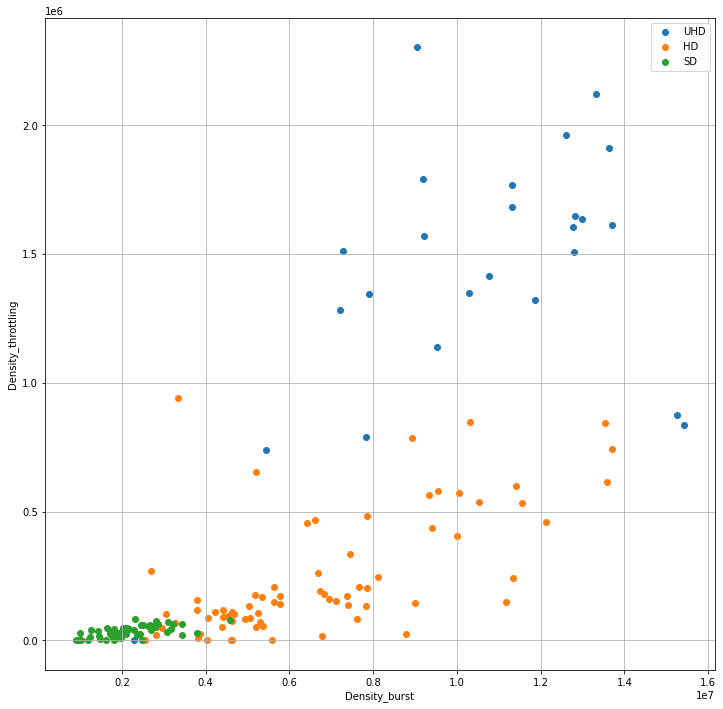

In [5]:
f = plt.figure()
f.set_figwidth(12)
f.set_figheight(12)

for quality_label in ['UHD', 'HD', 'SD']:
    x = []
    y = []
    for i in range(len(data)):
        if data['Quality_label'][i] == quality_label:
            x.append(data['Density_burst'][i])
            y.append(data['Density_throttling'][i])
    plt.scatter(x, y, label=quality_label)
    
plt.xlabel("Density_burst")
plt.ylabel("Density_throttling")
plt.legend()
plt.grid(True)

plt.show()

**Перемешаем строки**

In [6]:
data_shuffled = shuffle(data)
data_shuffled

,Density_burst,Density_throttling,Quality,Quality_label
132,1.788014e+06,8.894385e+03,360,SD
28,9.404043e+06,4.354933e+05,1440,HD
23,1.279386e+07,1.508739e+06,2160,UHD
56,9.005789e+06,1.460157e+05,1080,HD
78,4.611469e+06,1.618376e+03,720,HD
...,...,...,...,...
3,1.131292e+07,1.768927e+06,2160,UHD
94,5.628830e+06,1.501666e+05,720,HD
6,1.362896e+07,1.909877e+06,2160,UHD
100,1.806642e+06,1.185588e+03,480,SD


**Нормализуем данные**

In [7]:
data_norm = data_shuffled.copy()

for column in ['Density_burst', 'Density_throttling']:
    data_norm[column] = ((data_norm[column] - data_norm[column].min()) /
                            (data_norm[column].max() - data_norm[column].min()))
    
data_norm

,Density_burst,Density_throttling,Quality,Quality_label
132,0.061709,0.003487,360,SD
28,0.585505,0.188908,1440,HD
23,0.818642,0.655391,2160,UHD
56,0.558115,0.063087,1080,HD
78,0.255894,0.000325,720,HD
...,...,...,...,...
3,0.716790,0.768481,2160,UHD
94,0.325863,0.064891,720,HD
6,0.876076,0.829745,2160,UHD
100,0.062990,0.000137,480,SD


**KNN**

In [8]:
X = data_norm[['Density_burst', 'Density_throttling']]
y = data_norm['Quality_label']

best_score = 0.0
i_best_score = 0
for i in range(1, 30):
    model = KNeighborsClassifier(n_neighbors = i)
    scores = cross_val_score(model, X, y, cv=10, scoring = 'accuracy')
    n_spaces = 1 - i // 10
    print(i, ' ' * n_spaces, scores.mean())
    if (scores.mean() > best_score):
        best_score = scores.mean()
        i_best_score = i

print("\nЛучший резульат:\nn =", i_best_score, "\naccuracy =", best_score)

1   0.8600000000000001
2   0.8400000000000001
3   0.8800000000000001
4   0.8866666666666667
5   0.8866666666666667
6   0.8866666666666667
7   0.9
8   0.8933333333333333
9   0.9
10  0.8933333333333333
11  0.8933333333333333
12  0.8933333333333333
13  0.8933333333333333
14  0.8866666666666667
15  0.8933333333333333
16  0.8933333333333333
17  0.8933333333333333
18  0.8933333333333333
19  0.9
20  0.8933333333333333
21  0.9
22  0.9
23  0.9
24  0.8933333333333333
25  0.9
26  0.8866666666666667
27  0.8866666666666667
28  0.8800000000000001
29  0.8866666666666667

Лучший резульат:
n = 7 
accuracy = 0.9


**Support Vector Classification**

In [9]:
best_score = 0.0
best_kernel = ''
for i_kernel in (['linear', 'poly', 'rbf', 'sigmoid']):
    X_norm = data_norm[['Density_burst', 'Density_throttling']]
    y_norm = data_norm['Quality_label']
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto', kernel=i_kernel))
    scores = cross_val_score(clf, X_norm, y_norm, cv=10, scoring = 'accuracy')
    n_spaces = 8 - len(i_kernel)
    print('kernel:', i_kernel, ' ' * n_spaces, 'scores_mean:', scores.mean())
    if (scores.mean() > best_score):
        best_score = scores.mean()
        best_kernel = i_kernel
        
print("\nЛучший резульат:\nkernel = ", best_kernel, "\naccuracy = ", best_score)

kernel: linear    scores_mean: 0.8866666666666667
kernel: poly      scores_mean: 0.8800000000000001
kernel: rbf       scores_mean: 0.8933333333333333
kernel: sigmoid   scores_mean: 0.6933333333333332

Лучший резульат:
kernel =  rbf 
accuracy =  0.8933333333333333


**CatBoost**

In [10]:
best_score = 0.0
best_params = []
for iter_param in ([100, 200, 500, 1000, 2000]):
    for cv_param in ([5, 10, 20]):
        for lr_param in ([0.05, 0.2, 0.5, 0.7, 1]):
            model = CatBoostClassifier(iterations=iter_param, learning_rate = lr_param, silent=True)
            scores = cross_val_score(model, X, y, cv=cv_param, scoring = 'accuracy')
            n_spaces_i = 1 - iter_param // 1000
            n_spaces_j = 1 - cv_param // 10
            n_spaces_k = 5 - len(str(lr_param))
            print('iterations:', iter_param, ' ' * n_spaces_i,
                  'cv:', cv_param, ' ' * n_spaces_j,
                  'learning_rate:', lr_param,' ' * n_spaces_k,
                  'scores_mean:', scores.mean())
            if (scores.mean() > best_score):
                best_score = scores.mean()
                best_params = [iter_param, cv_param, lr_param]

print("\nЛучший резульат:",
      "\niterations = ", best_params[0],
      "\ncv = ", best_params[1],
      "\nlearning_rate = ", best_params[2],
      "\naccuracy = ", best_score, sep = "")

iterations: 100   cv: 5   learning_rate: 0.05   scores_mean: 0.8800000000000001
iterations: 100   cv: 5   learning_rate: 0.2    scores_mean: 0.8666666666666668
iterations: 100   cv: 5   learning_rate: 0.5    scores_mean: 0.8266666666666668
iterations: 100   cv: 5   learning_rate: 0.7    scores_mean: 0.8266666666666665
iterations: 100   cv: 5   learning_rate: 1      scores_mean: 0.8266666666666665
iterations: 100   cv: 10  learning_rate: 0.05   scores_mean: 0.8933333333333333
iterations: 100   cv: 10  learning_rate: 0.2    scores_mean: 0.8600000000000001
iterations: 100   cv: 10  learning_rate: 0.5    scores_mean: 0.8600000000000001
iterations: 100   cv: 10  learning_rate: 0.7    scores_mean: 0.8533333333333335
iterations: 100   cv: 10  learning_rate: 1      scores_mean: 0.8533333333333335
iterations: 100   cv: 20  learning_rate: 0.05   scores_mean: 0.8866071428571429
iterations: 100   cv: 20  learning_rate: 0.2    scores_mean: 0.8616071428571429
iterations: 100   cv: 20  learning_rate: